<a href="https://colab.research.google.com/github/Jeremy-22/Tarea-6/blob/main/SolED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [59]:
class DESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        #batch_size=tf.shape(data)[0]
        batch_size=100

        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        #t = tf.random.uniform((batch_size,1), minval=0, maxval=15)
        with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred-(x**2)*(tf.math.cos(x)) #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic =  y_o - 0. #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Compute grad
        grads = tape.gradient(loss, self.trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [60]:
model = DESolver()
model.add(Dense(20, activation='tanh', input_shape=(1,)))
model.add(Dense(100, activation = 'tanh'))
model.add(Dense(150,activation='tanh'))
model.add(Dense(80, activation = 'tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation="tanh"))
model.add(Dense(1))


model.summary()
#model.summary()

Model: "de_solver_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 20)                40        
                                                                 
 dense_79 (Dense)            (None, 100)               2100      
                                                                 
 dense_80 (Dense)            (None, 150)               15150     
                                                                 
 dense_81 (Dense)            (None, 80)                12080     
                                                                 
 dense_82 (Dense)            (None, 50)                4050      
                                                                 
 dense_83 (Dense)            (None, 10)                510       
                                                                 
 dense_84 (Dense)            (None, 1)                 

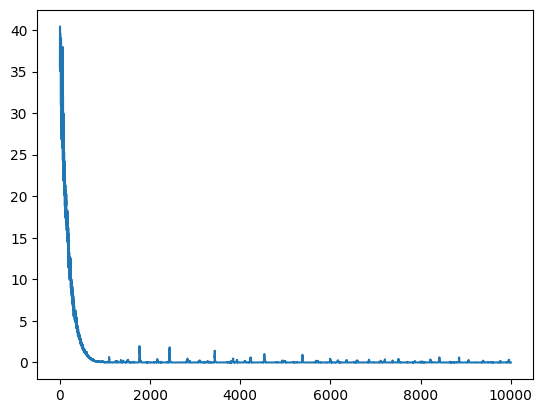

In [32]:
model.compile(optimizer=Adam(), metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=10000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 4ms/step


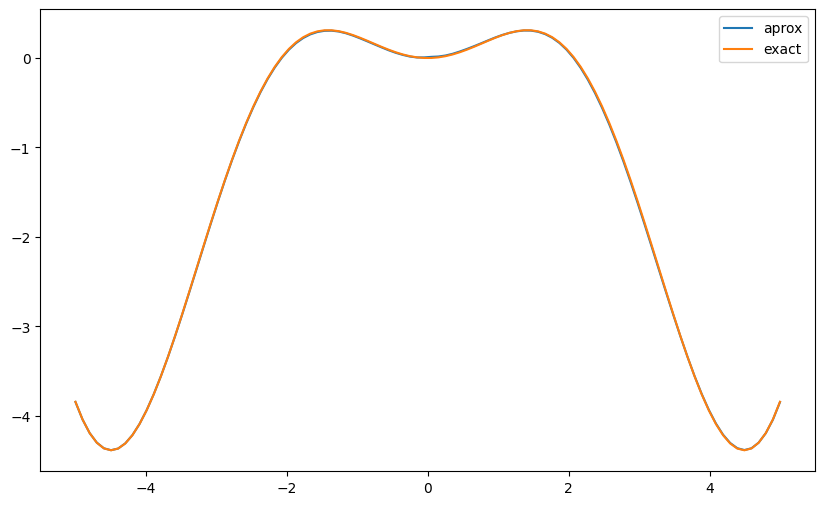

In [33]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.figure(figsize=(10,6))
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv,x*np.sin(x)+2*np.cos(x)-2*np.sin(x)/x,label="exact")
plt.legend()
plt.show()

In [15]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        batch_size= tf.shape(data)[0]

        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        x_o = tf.zeros((batch_size,1))

        with tf.GradientTape() as tape:

            with tf.GradientTape(persistent=True) as g:
                g.watch(x)

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    gg.watch(x_o)
                    y_pred = self(x, training=True)
                    y_o = self(x_o, training=True)

                y_x = gg.gradient(y_pred,x)
                y_xo = gg.gradient(y_o, x_o)

            y_xx = g.gradient(y_x,x)

            pde = y_xx + y_pred
            ic = y_o - 1.
            ic2 = y_xo + 0.5
            loss = self.mse(0., pde) + self.mse(0., ic) + self.mse(0., ic2)

        grads = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [16]:
model = PDESolver()
model.add(Dense(20, activation='tanh', input_shape=(1,)))
model.add(Dense(100, activation = 'tanh'))
model.add(Dense(150,activation='tanh'))
model.add(Dense(80, activation = 'tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation="tanh"))
model.add(Dense(1))


model.summary()

Model: "pde_solver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                40        
                                                                 
 dense_17 (Dense)            (None, 100)               2100      
                                                                 
 dense_18 (Dense)            (None, 150)               15150     
                                                                 
 dense_19 (Dense)            (None, 80)                12080     
                                                                 
 dense_20 (Dense)            (None, 50)                4050      
                                                                 
 dense_21 (Dense)            (None, 10)                510       
                                                                 
 dense_22 (Dense)            (None, 1)                

In [17]:
model.compile(optimizer="RMSprop")

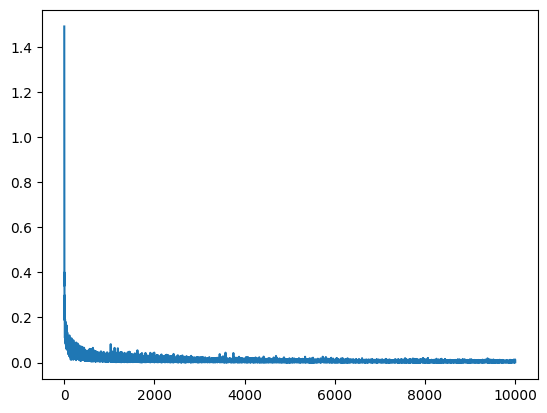

In [18]:
x=tf.linspace(-5, 5, 100)
history = model.fit(x,epochs=10000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 4ms/step


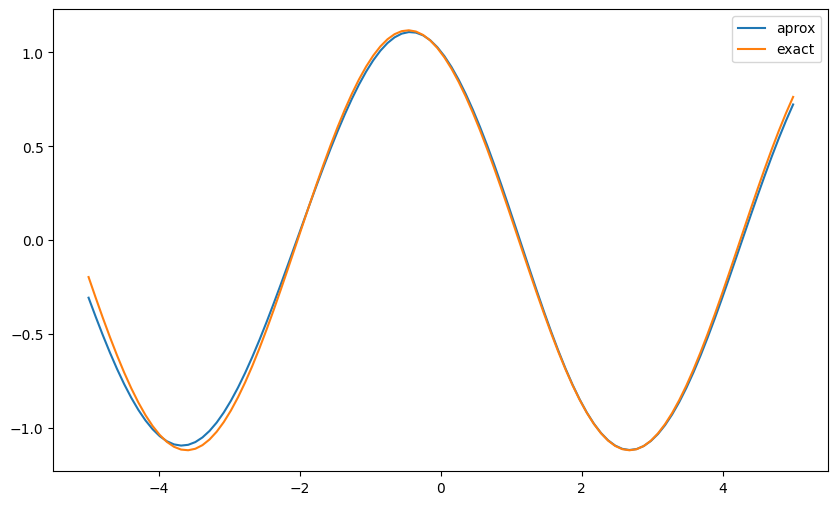

In [19]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.figure(figsize=(10,6))
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, np.cos(x)-(0.5)*np.sin(x),label="exact")
plt.legend()
plt.show()